In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.portfolio_management.portfolio import Portfolio, OptimizedPortfolio
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

In [47]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Indicator:
                price = member.calculate(price,timeframe=28)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4006/4006 [03:31<00:00, 18.98it/s]


In [48]:
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["market_cap"] = simulation["market_cap"].astype(float)
simulation["asset_class"] = "common_stock"
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())

simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low',
       'rolling_dollar_volume', 'adr', 'sma', 'sma_corr', 'ema', 'ema_corr',
       'bollinger_upper', 'bollinger_lower', 'momentum', 'roc', 'williams_r',
       'obv', 'vwap', 'market_impact', 'atr', 'coefficient_of_variation',
       'name', 'market_cap', 'office', 'sic_description', 'asset_class'],
      dtype='object')

In [49]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [138]:
orivault.connect()
a = orivault.retrieve("results")
orivault.disconnect()

In [139]:
valid = a[(a["position_type"]=="long") & (a["selection_type"]!="long_short")].sort_values("pnl",ascending=False).head(20)
valid

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio
34,ema_corr,MONTH,long,OFFICE,top,equal,coefficient_of_variation,0.5,2024-12-31,51.371570,0.652444,78.737190,1.275511,0.783916,0.476515,1.018169,0.579112
10,ema_corr,QUARTER,long,OFFICE,top,equal,coefficient_of_variation,0.5,2024-12-31,6.956573,0.506650,13.730527,1.456946,0.647871,0.488636,1.043214,0.129173
58,ema_corr,WEEK,long,OFFICE,top,equal,coefficient_of_variation,0.5,2024-12-20,4.733897,0.426416,11.101593,1.104426,0.903409,0.502000,1.004319,-0.046011
24,ema_corr,MONTH,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.5,2024-12-31,2.407403,2.289009,1.051723,1.096133,0.906737,0.504275,1.002245,-3.200920
26,ema_corr,MONTH,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.5,2024-12-31,2.394015,2.910681,0.822493,1.103455,0.902809,0.506783,1.004493,-4.109296
50,ema_corr,WEEK,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.5,2024-12-20,1.862227,4.265893,0.436539,1.041035,0.958595,0.518826,1.001367,-7.748374
2,ema_corr,QUARTER,long,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.5,2024-12-31,1.359694,2.251107,0.604012,1.204697,0.824501,0.521638,1.022826,-6.329790
0,ema_corr,QUARTER,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.5,2024-12-31,1.003505,0.966547,1.038237,1.188025,0.831864,0.522048,1.017797,-4.025534
48,ema_corr,WEEK,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.5,2024-12-20,0.921515,3.427544,0.268856,1.038247,0.959705,0.517401,1.000343,-16.079902
8,ema_corr,QUARTER,long,OFFICE,mixed,equal,coefficient_of_variation,0.5,2024-12-31,0.610603,0.566145,1.078528,1.341774,0.669995,0.487500,0.997488,-4.239442


In [140]:
top = valid.head().to_dict("records")[0]
top

{'ranking_metric': 'ema_corr',
 'timeframe': 'MONTH',
 'position_type': 'long',
 'grouping_type': 'OFFICE',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-31 00:00:00'),
 'pnl': 51.3715696766833,
 'coefficient_of_variation': 0.6524435195319358,
 'portfolio_std': 78.73719048284418,
 'average_gain': 1.2755111577935694,
 'average_loss': 0.7839164245741314,
 'win_loss_ratio': 0.4765151515151515,
 'weekly_return': 1.0181687633582424,
 'sharpe_ratio': 0.5791124430057878}

In [141]:
base_portfolio = Portfolio.from_dict(top)

In [142]:
portfolios = PortfolioSelection.optimize_portfolio(base_portfolio,group_percentages=[0.005,0.01])

In [143]:
analysises = []
for portfolio in tqdm(portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = Metrics.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:01<00:00, 10.19s/it]


In [144]:
a = pd.DataFrame(analysises)
a.reset_index().drop("date",axis=1).sort_values("sharpe_ratio",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
4,4,ema_corr,MONTH,long,OFFICE,top,market_cap,coefficient_of_variation,0.010,3107.133211,2.210587,1405.569358,1.017332,0.993192,0.453320,1.004136,2.206479,<financial_common.portfolio_management.portfol...
5,5,ema_corr,MONTH,long,OFFICE,top,risk,coefficient_of_variation,0.010,153.784630,2.131280,72.156006,1.018377,0.988719,0.430401,1.001484,2.051260,<financial_common.portfolio_management.portfol...
1,1,ema_corr,MONTH,long,OFFICE,top,market_cap,coefficient_of_variation,0.005,66.347920,2.232779,29.715393,1.041567,0.981889,0.450622,1.008782,2.038473,<financial_common.portfolio_management.portfol...
2,2,ema_corr,MONTH,long,OFFICE,top,risk,coefficient_of_variation,0.005,9.928431,2.324971,4.270346,1.041972,0.969656,0.428216,1.000623,0.972883,<financial_common.portfolio_management.portfol...
3,3,ema_corr,MONTH,long,OFFICE,top,equal,coefficient_of_variation,0.010,4399.709828,0.565232,7783.905334,1.254938,0.792758,0.462757,1.006635,0.564490,<financial_common.portfolio_management.portfol...
0,0,ema_corr,MONTH,long,OFFICE,top,equal,coefficient_of_variation,0.005,56.506706,0.574745,98.316209,1.298310,0.766380,0.464730,1.013584,0.516017,<financial_common.portfolio_management.portfol...


In [145]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

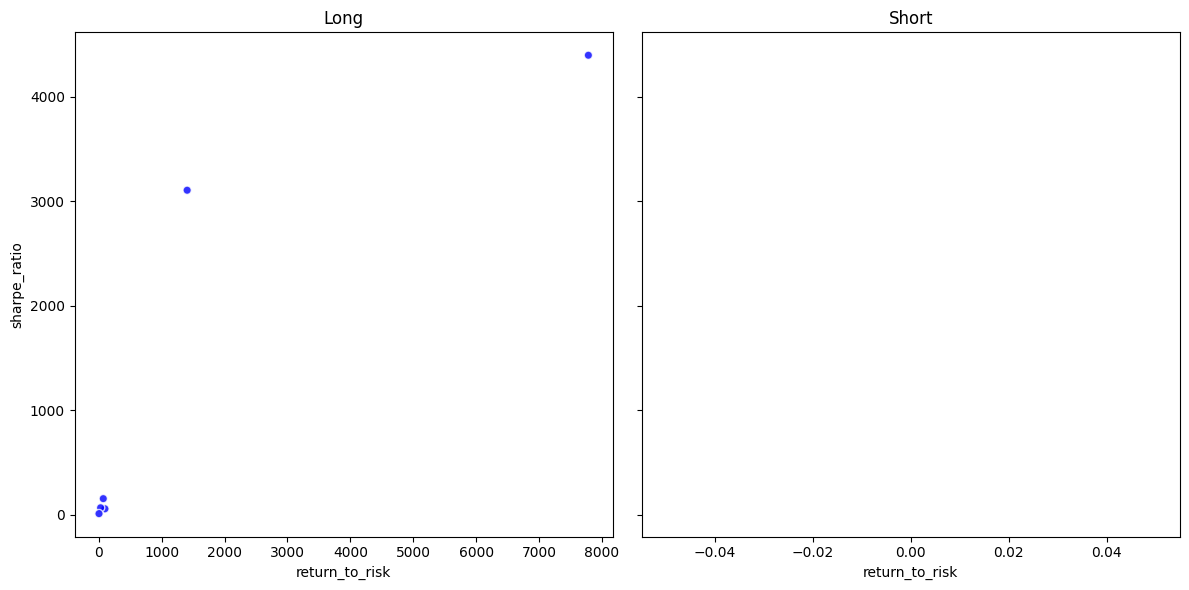

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [152]:
top = a.sort_values("sharpe_ratio",ascending=False).iloc[0].to_dict()
top

{'ranking_metric': 'ema_corr',
 'timeframe': 'MONTH',
 'position_type': 'long',
 'grouping_type': 'OFFICE',
 'selection_type': 'top',
 'allocation_type': 'market_cap',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.01,
 'date': Timestamp('2024-12-31 00:00:00+0000', tz='UTC'),
 'pnl': 3107.1332112168025,
 'coefficient_of_variation': 2.2105869006462435,
 'portfolio_std': 1405.569358213632,
 'average_gain': 1.0173324141725684,
 'average_loss': 0.9931924821073688,
 'win_loss_ratio': 0.45331985170205596,
 'weekly_return': 1.0041355925312627,
 'sharpe_ratio': 2.2064790400792704,
 'portfolio': <financial_common.portfolio_management.portfolio.OptimizedPortfolio at 0x23294a2e610>,
 'color': 'blue',
 'return_to_risk': 2.2105869006462435}

In [153]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

In [154]:
portfolio.sort_values("return",ascending=False).head(20)

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week
87,2019-07-30 00:00:00+00:00,1.800000,510.325886,98.704471,2.389829,2019,7,3,31
72,2018-12-28 00:00:00+00:00,1.800000,28.039408,80.819425,1.956797,2018,12,4,52
75,2019-02-12 00:00:00+00:00,1.800000,50.407186,86.340843,2.090481,2019,2,1,7
76,2019-02-20 00:00:00+00:00,1.800000,90.732935,88.941167,2.153440,2019,2,1,8
114,2020-06-25 00:00:00+00:00,1.800000,3098.000866,85.778274,2.076860,2020,6,2,26
85,2019-06-27 00:00:00+00:00,1.800000,283.007199,92.286123,2.234428,2019,6,2,26
47,2017-12-28 00:00:00+00:00,1.668333,4.148610,87.972919,2.129997,2017,12,4,52
25,2016-10-28 00:00:00+00:00,1.640976,2.892375,55.157780,1.335478,2016,10,4,43
77,2019-02-22 00:00:00+00:00,1.640625,148.858721,88.360512,2.139381,2019,2,1,8
105,2020-04-27 00:00:00+00:00,1.592432,1674.291920,82.853616,2.006049,2020,4,2,18


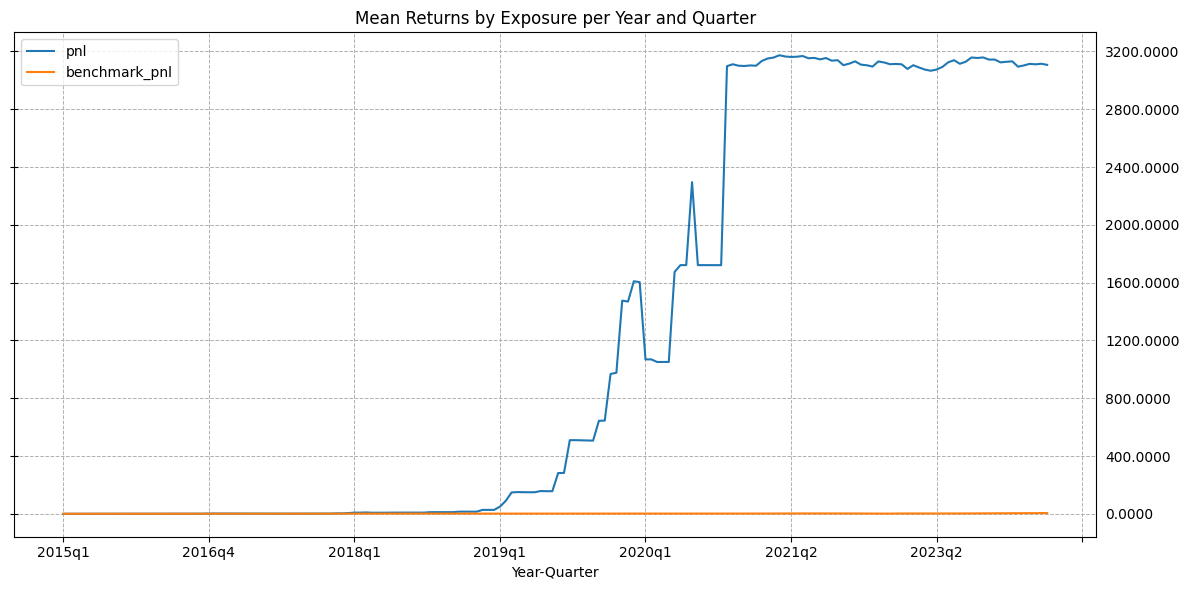

In [155]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [156]:
trades.sort_values("return",ascending=False).dropna()

,year,month,ticker,date,adjclose,sell_price,office,ema_corr,coefficient_of_variation,market_cap_x,...,position_type,group_market_cap,weight,unweighted_return,winsorized_return,return,name,market_cap_y,quarter,week
317,2018,12,GCTK,2018-12-28 00:00:00+00:00,221.0000,650.0000,Industrial Applications and Services,2.522523,0.534982,4.093736e+06,...,1.0,4.093736e+06,1.000000,1.800000,1.800000,1.800000,"GlucoTrack, Inc. Common Stock",4.093736e+06,4,52
1697,2020,6,APLD,2020-06-25 00:00:00+00:00,0.0426,0.0900,Office of Technology,1.398392,0.362627,1.056173e+09,...,1.0,1.056173e+09,1.000000,1.800000,1.800000,1.800000,Applied Digital Corporation Common Stock,1.056173e+09,2,26
807,2019,6,GAME,2019-06-27 00:00:00+00:00,2.1510,5.1000,Office of Trade & Services,1.796547,0.332080,2.913848e+07,...,1.0,2.913848e+07,1.000000,1.800000,1.800000,1.800000,"GameSquare Holdings, Inc. Common Stock",2.913848e+07,2,26
1210,2019,7,GAME,2019-07-30 00:00:00+00:00,5.1000,22.9500,Office of Trade & Services,1.545395,0.699914,2.913848e+07,...,1.0,2.913848e+07,1.000000,1.800000,1.800000,1.800000,"GameSquare Holdings, Inc. Common Stock",2.913848e+07,3,31
118,2019,2,GAME,2019-02-20 00:00:00+00:00,1.5000,5.9700,Office of Trade & Services,3.843714,0.316067,2.913848e+07,...,1.0,2.913848e+07,1.000000,1.800000,1.800000,1.800000,"GameSquare Holdings, Inc. Common Stock",2.913848e+07,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,2015,11,MDGL,2015-11-30 00:00:00+00:00,23.8000,14.9765,Office of Life Sciences,2.073326,0.226768,7.103496e+09,...,1.0,2.052255e+10,0.346131,0.629265,0.629265,0.871677,"Madrigal Pharmaceuticals, Inc. Common Stock",7.103496e+09,4,49
637,2022,1,BBIO,2022-01-31 00:00:00+00:00,17.1600,9.8700,Office of Life Sciences,1.985895,0.197337,6.893620e+09,...,1.0,1.477125e+10,0.466692,0.575175,0.575175,0.801738,"BridgeBio Pharma, Inc. Common Stock",6.893620e+09,1,5
2150,2020,5,AXIL,2020-05-26 00:00:00+00:00,3.2000,2.4000,Industrial Applications and Services,1.285821,0.440603,4.368953e+07,...,1.0,4.368953e+07,1.000000,0.750000,0.750000,0.750000,"AXIL Brands, Inc.",4.368953e+07,2,22
1579,2022,12,CVNA,2022-12-30 00:00:00+00:00,8.1300,4.7400,Office of Trade & Services,1.429817,0.507721,3.157321e+10,...,1.0,4.325568e+10,0.729921,0.583026,0.583026,0.695642,Carvana Co.,3.157321e+10,4,52
